In [1]:
from astropy.io import fits
from astropy.visualization import LogStretch,SqrtStretch
from matplotlib import pyplot as plt
from monai.transforms import *
import numpy as np
import torch
import cv2
from scipy import ndimage
import math

In [126]:
im_path = "/home/dguthruf/Dev/astro-deconv/data/raw/hubble/base/hst_13003_26_wfc3_uvis_f606w.fits"
hdul = fits.open(im_path)
data = hdul[1].data
stretch = LogStretch()
sdata = stretch(data)


In [133]:
hdul[1].name

'SCI'

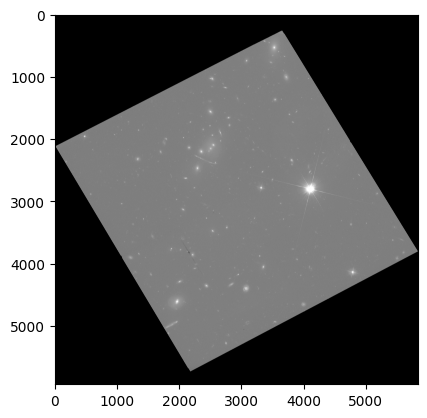

In [127]:
plt.imshow(sdata,cmap="gray")

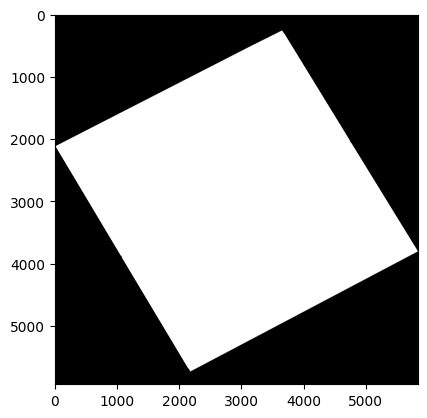

In [128]:
label = np.where(data>0.00000001,255,0).astype(np.uint8)
plt.imshow(label,cmap="gray")

59.160736083984375


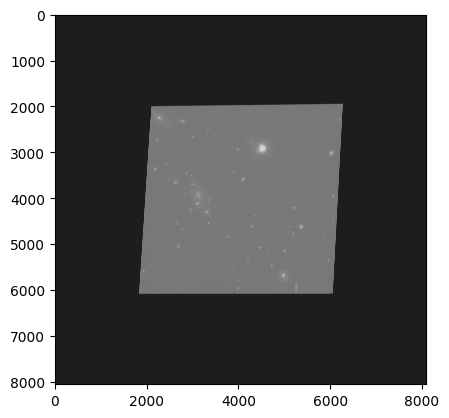

In [129]:
def crop(image):
    i = 1 if len(hdul) > 1 else 0
    h,w = image.shape
    y_nonzero, x_nonzero= np.nonzero(image)
    ysen = int(np.maximum(np.min(y_nonzero),h-np.max(y_nonzero))+0.05*h)
    xsen = int(np.maximum(np.min(x_nonzero),w-np.max(x_nonzero))+0.05*w)
    cropped_image= image[ysen:h-ysen,xsen:w-xsen]
    return cropped_image
# th, threshed = cv2.threshold(label, 0,1, cv2.THRESH_BINARY_INV)
cnts = cv2.findContours(label, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
cnt = sorted(cnts, key=cv2.contourArea)[-1]
rot_rect = cv2.minAreaRect(cnt)

cx,cy = (rot_rect[0][0], rot_rect[0][1]) # rect center
sx,sy = (rot_rect[1][0], rot_rect[1][1]) # rect size
angle = rot_rect[2] # rect angle
print(angle)
rotated_image=ndimage.rotate(sdata, angle)
plt.imshow(rotated_image,cmap="gray")



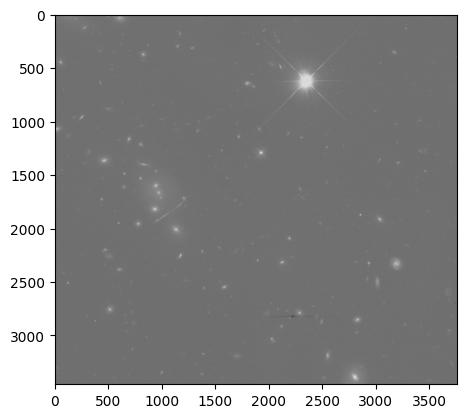

In [130]:
cropped_image=crop(rotated_image)
plt.imshow(cropped_image,cmap="gray")

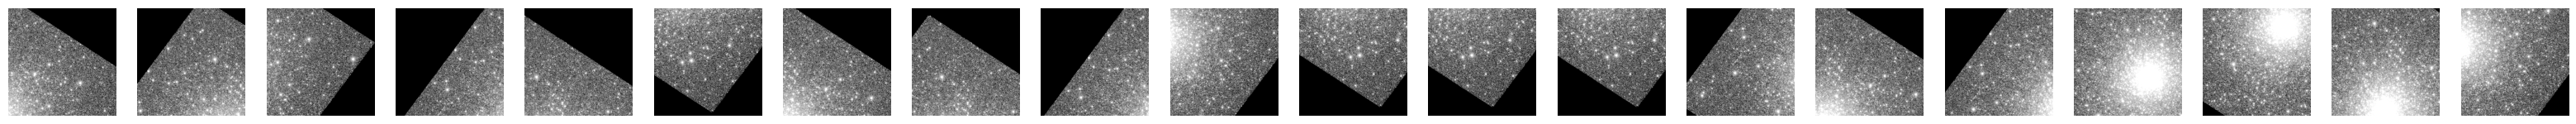

In [41]:
label = np.where(data>0,1,0).astype(np.float32)
data3=np.expand_dims(data,axis=0).astype(np.float32)
sdata3=np.expand_dims(sdata,axis=0).astype(np.float32)
label3=np.expand_dims(label,axis=0).astype(np.float32)
Cropa = Compose([RandCropByPosNegLabel(spatial_size=(512,512),
                                       pos=1,neg=0.,
                                       num_samples=20,
                                       label=label3,
                                       allow_smaller=False,
                                       image=sdata3,image_threshold=0.1
                                       ),
                 ])
images = Cropa(sdata3.astype(np.float32))
fig, axs = plt.subplots(1, len(images), figsize=(40, 40))

# plot each image in its own subplot
for i, ax in enumerate(axs):
    ax.imshow(images[i][0], cmap='gray')
    ax.set_axis_off()

plt.show()

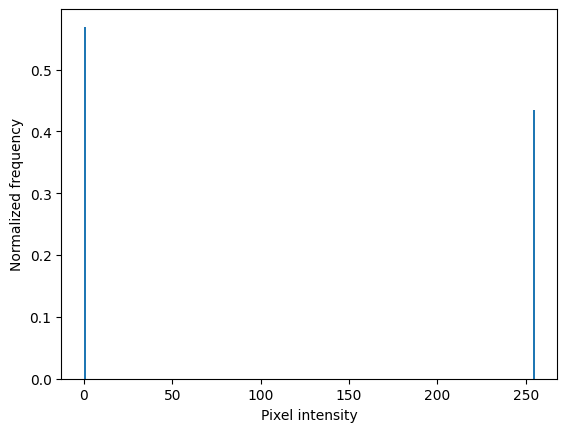

In [42]:
plt.hist(sdata.flatten(), bins=256, range=(0, 1), density=True)
plt.xlabel('Pixel intensity')
plt.ylabel('Normalized frequency')
plt.show()

In [43]:
label = np.where(data>0,255,0).astype(np.uint8)
ret, thresh = cv2.threshold(label, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
max_contour = max(contours, key=cv2.contourArea)
rect = cv2.minAreaRect(max_contour)
angle = rect[2]
print('Angle of rotation:', angle)

Angle of rotation: 90.0


In [44]:
img_edges = cv2.Canny(label, 100, 100, apertureSize=3)
lines = cv2.HoughLinesP(img_edges, 1, math.pi / 180.0, 100, minLineLength=100, maxLineGap=5)
angles = []
key = cv2.waitKey(0)

for [[x1, y1, x2, y2]] in lines:
    cv2.line(label, (x1, y1), (x2, y2), (255, 0, 0), 3)
    angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
    angles.append(angle)
    
cv2.imshow("Detected lines", label)    
key = cv2.waitKey(0)
median_angle = np.median(angles)
img_rotated = ndimage.rotate(label, median_angle)

print(f"Angle is {median_angle:.04f}")
# cv2.imwrite('rotated.jpg', img_rotated)  

In [156]:
math.degrees(median_angle)

48.283294662665966